In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
def repact_pbound(p_seq, r_seq, a_seq,
                  p_emat, r_emat, a_emat, 
                  n_p, n_r, n_a, n_NS,
                  ep_wt=0, er_wt=0, ea_wt=0, e_int=0):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)
    w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)

    z = np.zeros(5)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r / n_NS * w_r
    z[3] = n_a / n_NS * w_a
    z[4] = (n_p / n_NS * w_p) * (n_a / n_NS * w_a) * np.exp(-e_int)
    pbound = (z[1] + z[4]) / np.sum(z)
    
    return pbound

In [7]:
def repact_helper(mutants, rnap_start, rnap_end, rep_start, rep_end, act_start, act_end,
                  p_emat, r_emat, a_emat, n_p, n_r, n_a, n_NS,
                  ep_wt=0, er_wt=0, ea_wt=0, e_int=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()
        act_mut = mut[act_start:act_end].upper()
        rv['pbound'] = repact_pbound(rnap_mut, rep_mut, act_mut,
                                     p_emat, r_emat, a_emat, 
                                     n_p, n_r, n_a, n_NS,
                                     ep_wt=ep_wt, er_wt=er_wt, ea_wt=ea_wt, e_int=e_int)
        l_tr.append(rv)
    df_repact = pd.DataFrame.from_records(l_tr)

    return df_repact


def repact(wtseq, rnap_wtseq, rep_wtseq, act_wtseq, p_emat, r_emat, a_emat, 
           ep_wt, er_wt, ea_wt, e_int, n_NS, n_p, n_r, n_a,
           num_mutants=10000, mutrate=0.1, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)
    act_start, act_end = tregs.seq_utils.find_binding_site(wtseq, act_wtseq)

    df_repact = repact_helper(mutants, rnap_start, rnap_end, rep_start, rep_end, act_start, act_end,
                              p_emat, r_emat, a_emat, n_p, n_r, n_a, n_NS,
                              ep_wt=ep_wt, er_wt=er_wt, ea_wt=ea_wt, e_int=e_int)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_repact))
    df_repact['ct_0'] = dna_cnt
    df_repact = df_repact[df_repact.ct_0 != 0.0]

    df_repact['ct_1'] = 0.1 + df_repact['ct_0'] * df_repact['pbound'] * scaling_factor
    df_repact['ct_1'] = df_repact['ct_1'].astype(int)

    df_repact['ct_0'] = df_repact['ct_0'].astype(float)
    df_repact['ct_1'] = df_repact['ct_1'].astype(float)
    df_repact['norm_ct_1'] = df_repact['ct_1'] / df_repact['ct_0']

    return df_repact

In [8]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [9]:
def plot_footprint(df, rep_start_site, act_start_site):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(rep_start_site, rep_start_site + 10, alpha=0.7, color='#E8B19D')
    ax.axvspan(act_start_site, act_start_site + 10, alpha=0.7, color='#DCECCB')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')


    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((rep_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep_start_site + 0.5 * 10, max(footprint) * 1.2, 'R', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((act_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#7AA974',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(act_start_site + 0.5 * 10, max(footprint) * 1.2, 'A', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    #plt.savefig('../figs/repact_footprint_overlapping.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
rep_site = promoter[115:(115+10)]
act_site = promoter[(115 - 90 + 15):(115 - 90 + 25)]
r_emat = generate_emap(rep_site, fixed=True, fixed_value=2)
a_emat = generate_emap(act_site, fixed=True, fixed_value=2)

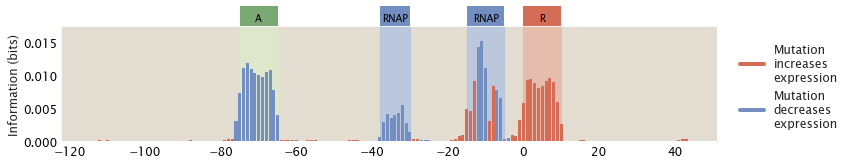

In [11]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -7
e_int = -6
n_p, n_r, n_a = 4600, 50, 50

df = repact(promoter, rnap_site, rep_site, act_site, rnap_emat, r_emat, a_emat, 
            ep_wt, er_wt, ea_wt, e_int, n_NS, n_p, n_r, n_a, scaling_factor=10*6)
plot_footprint(df, 0, 15-90)